## This notebook attempts to carry out sentiment analysis on the Endsars Twitter protests.

Because the dataset does not contains sentiment labels, 2 approaches were employed to label the dataset:

1. A lexicon based approach using Varder sentiment analyzer (from the NLTK library) and Text Blob.
 
2. Transfer learning, by training on labelled tweeets and predicting on our dataset.

In [1]:
# Import libraries

import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english')) 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import textblob
import matplotlib.pyplot as plt

In [3]:
# Load dataset

tweet_df = pd.read_pickle('preprocessed_data.pkl')

tweet_df.reset_index(drop=True, inplace=True)
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78731 entries, 0 to 78730
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   78731 non-null  object             
 1   author_id            78731 non-null  object             
 2   text                 78731 non-null  object             
 3   created_at           78731 non-null  datetime64[ns, UTC]
 4   referenced_tweets    59090 non-null  object             
 5   withheld             3 non-null      object             
 6   user_public_metrics  78643 non-null  object             
 7   user_location        57788 non-null  object             
 8   user_created_at      78643 non-null  object             
 9   user_name            78643 non-null  object             
 10  username             78643 non-null  object             
 11  user_verified        78643 non-null  object             
 12  possibly_sensitive

In [8]:
# get sentiment score using Vader lexicon

def return_sentiment(scores):

#     if scores['compound']<=1 and scores['compound']>=0.55:
#         return 'very_positive'
#     elif scores['compound']<=0.55 and scores['compound']>=0.1:
#         return 'positive'
#     elif scores['compound']<=0.1 and scores['compound']>=-0.1:
#         return 'neutral'
#     elif scores['compound']<=-0.1 and scores['compound']>=-0.55:
#         return 'negative'
#     else: return 'very_negative'
    
    if scores['compound']>0.1 and scores['compound']<=1:
        return 'positive'
    elif scores['compound']>=-0.1 and scores['compound']<=0.1:
        return 'neutral'
    else: return 'negative'
        

analyzer = SentimentIntensityAnalyzer()

tweet_df['Vader_sentiment_score'] = tweet_df.joined_text.dropna().apply(analyzer.polarity_scores)
tweet_df['Vader_sentiment'] = tweet_df['Vader_sentiment_score'].apply(return_sentiment)

In [9]:
# tweets labelled postive by Varder lexicon analyzer
tweet_df[tweet_df.Vader_sentiment=='positive'][['text', 'Vader_sentiment']]

,text,Vader_sentiment
1,Even God love dreads that was why he gave sams...,positive
4,@segalink I honestly don't know why some peopl...,positive
6,RT @JuicyiMos: How about 10k for ten people?\n...,positive
7,Somebody said\nSEX is the only time you're bee...,positive
10,Wallpaper series\n.\nShot and edited with a @T...,positive
...,...,...
78717,RT @JaneyBuz: 🚨NEW VIDEO ALERT🚨\n\nHello Beaut...,positive
78719,"RT @SaharaReporters: VIDEO: Despite Outrage, @...",positive
78725,RT @FlipmemesDotCom: FG To Treat Fresh #endsar...,positive
78728,"RT @stewardjornsen: @channelstv In retrospect,...",positive


In [13]:
# Get sentiment score using textblob

def textblob_sentiment():
    label = []
    for row in tweet_df['joined_text'].values:
        score = textblob.TextBlob(row).sentiment.polarity
        if score>0 and score<=1:
            label.append('positive')
        elif score>=-1 and score<0:
            label.append('negative')
        elif score == 0:
            label.append('neutral')
    tweet_df['Textblob_sentiment'] = label
    
textblob_sentiment()

In [14]:
# tweets labelled postive by textblob
tweet_df[tweet_df.Textblob_sentiment=='positive'][['text', 'Textblob_sentiment']]

,text,Textblob_sentiment
4,@segalink I honestly don't know why some peopl...,positive
9,RT @AkwariCharles: I am so glad she is safe. T...,positive
14,RT @ChiefOjukwu: 8. who gets his oxygen from s...,positive
15,RT @Apholerbee: @ChiefOjukwu @segalink Did you...,positive
20,Still up to Grow your Twitter??\nFollow Me To ...,positive
...,...,...
78717,RT @JaneyBuz: 🚨NEW VIDEO ALERT🚨\n\nHello Beaut...,positive
78720,“The #EndSars protests show us what young peop...,positive
78725,RT @FlipmemesDotCom: FG To Treat Fresh #endsar...,positive
78729,EPISODE 3 IS NOW LIVE! We have partnered with ...,positive


In [15]:
#  Get sentiment labels using transfer learning (fasttext)
# see notebook titled ... to see how training was carried out

from fasttext import load_model
import fasttext

model = load_model('../model140.ftz')
tweet_df['fasttext140_sentiment'] = tweet_df['joined_text'].apply(lambda x:model.predict(x)[0][0])

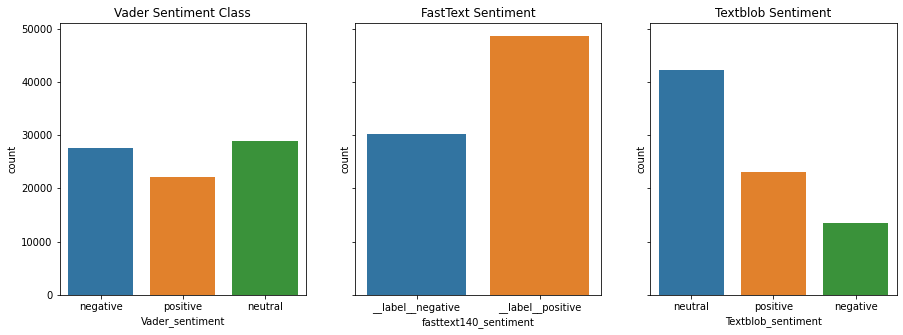

In [16]:
# comparing results of the 3 models

def plot():
    fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))

    sns.countplot(ax=axes[0], x=tweet_df['Vader_sentiment'])
    axes[0].set_title('Vader Sentiment Class')

    sns.countplot(ax=axes[1], x=tweet_df['fasttext140_sentiment'])
    axes[1].set_title('FastText Sentiment')

    sns.countplot(ax=axes[2], x=tweet_df['Textblob_sentiment'])
    axes[2].set_title('Textblob Sentiment')
    
plot()